# Pre-Analysis of SL System DESJ0408-5354
This notebook takes the drizzled HST images and extracts the information (e.g. cutout of image, PSF and noise estimates) to be used in the subsequent modelling process.

### import libraries

In [1]:
import numpy as np
import os
import h5py

import lenstronomy.Util.kernel_util as kernel_util
import lenstronomy.Util.util as util
from astroObjectAnalyser.DataAnalysis.analysis import Analysis
from astroObjectAnalyser.astro_object_superclass import StrongLensSystem

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable

### read in data from fits files

In [2]:
system_name = 'DESJ0408-5354'

ra_str = '04:08:21.71'
dec_str = '-53:53:59.34'

system = StrongLensSystem(system_name)
system.add_info_attribute('ra_str', ra_str)
system.add_info_attribute('dec_str', dec_str)

image_name = 'F160W'
image_filename = 'DESJ0408-5354_F160W_drz_sci.fits'
wht_filename = "DESJ0408-5354_F160W_drz_wht.fits"
cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print(base_path)

# import the data
local_filename = os.path.join(base_path, 'data', 'reduced_data', image_filename)
local_wht_filename = os.path.join(base_path, 'data', 'reduced_data', wht_filename)


# add image data instance (see astroObjectAnalyser)
# options for cutout
numPix = 120 # only even numbers allowed so far
system.add_image_data_init(image_name, local_filename=local_filename, local_psf_filename=None, 
                    local_wht_filename=local_wht_filename,
                       ra=system.ra, dec=system.dec, ra_cutout_cent=system.ra, dec_cutout_cent=system.dec,
                       cutout_scale=numPix, data_type='HST_new')

print(system.ra, system.dec)
print(system.ra_str, system.dec_str)

/Users/ajshajib/Research/time_delay_cosmography/J0408
(62.09045833333333, -53.899816666666666)
('04:08:21.71', '-53:53:59.34')


## show image and determine shift and positions of point sources

the center of the image is at pixel coordinates 1050.935367, 935.079250.


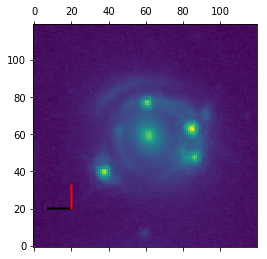

In [3]:

data_cutout = system.get_cutout_image(image_name, numPix, force=True)  # if force=True, a new cutout with the new options will be made

#%matplotlib notebook

plt.matshow(np.log10(data_cutout), origin='lower')
plt.autoscale(False)

ra0, dec0 = system.pix2coord(image_name, 20, 20)
xx_, yy_ = system.coord2pix(image_name, ra0, dec0)
xx_ra, yy_ra = system.coord2pix(image_name, ra0 + 1, dec0)
xx_dec, yy_dec = system.coord2pix(image_name, ra0, dec0 + 1)
plt.plot([xx_,xx_ra],[yy_,yy_ra], linewidth=2, color='k')
plt.plot([xx_,xx_dec],[yy_,yy_dec], linewidth=2, color='r')
plt.show()


0.0799999999999992
No filter file found, using default filter
No NNW file found, using default NNW config
sextractor command: sex /Users/ajshajib/Research/time_delay_cosmography/J0408/data/reduced_data/DESJ0408-5354_F160W_drz_sci.fits -c .pysex.sex -STARNNW_NAME .pysex.nnw -PARAMETERS_NAME .pysex.param -FILTER_NAME .pysex.conv -GAIN 5492.330935 -CATALOG_NAME .pysex.cat
(0.1751952171326, 0.01063104812056)
2.5
the center of the image is at pixel coordinates 1050.935367, 935.079250.
separate exposure map loaded


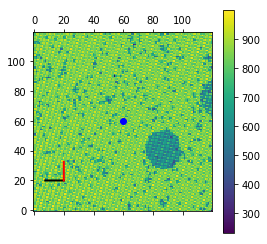

/Users/ajshajib/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in log10


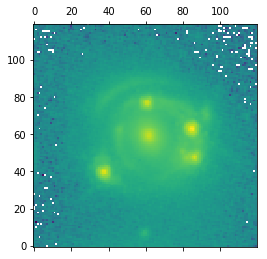

In [4]:
deltaPix, _ = system.get_pixel_scale(image_name)
deltaPix *= 3600  # convert into arcsec
print(deltaPix)
# get mean and sigma_bkd of image (computed by SourceExtractor)
mean, sigma_b = system.get_background(image_name)
ccd_gain = system.get_CCD_gain(image_name)
print(mean, sigma_b)
print(ccd_gain)

# we subtract the mean background estimate from the cutout image
data_reduced = (data_cutout - mean)#*mask_off


# get exposure time
exp_time = system.get_exposure_time(image_name)

# here we set the coordinate grid (rectangular)
ra_at_xy_0, dec_at_xy_0 = system.coord_at_pixel_0(image_name)
x_at_radec_0, y_at_radec_0 = system.pixel_at_angle_0(image_name)
Matrix = system.get_transform_matrix_angle2pix(image_name)
Matrix_inv = system.get_transform_matrix_pix2angle(image_name)
cos_dec = np.cos(system.dec/360*2*np.pi)


# get weight map (effective exposure time per pixel)
wht_map = system.get_exposure_map(image_name)
# untis in pixels are originally electrons/s

# for numerics, replace 0 with small number
wht_map[wht_map <= 0] = 10**(-10)  # just making sure that there are non-negative exposure times

plt.matshow((wht_map), origin='lower')
plt.autoscale(False)

ra0, dec0 = system.pix2coord(image_name, 20, 20)
xx_, yy_ = system.coord2pix(image_name, ra0, dec0)
xx_ra, yy_ra = system.coord2pix(image_name, ra0 + 1, dec0)
xx_dec, yy_dec = system.coord2pix(image_name, ra0, dec0 + 1)
plt.plot([xx_,xx_ra],[yy_,yy_ra], linewidth=2, color='k')
plt.plot([xx_,xx_dec],[yy_,yy_dec], linewidth=2, color='r')
 
x_0, y_0 = system.pixel_at_angle_0(image_name)
plt.plot(x_0, y_0, 'ob')
plt.colorbar()
plt.show()

plt.matshow(np.log10(data_reduced), origin='lower')
plt.show()

In [5]:
# save data configurations ih hdf5 format
data_filename = 'data_f160w.hdf5'
local_data_filename = os.path.join(base_path, 'data', data_filename)
f = h5py.File(local_data_filename, "w")
dset = f.create_dataset('image_data', data=data_reduced)
dset = f.create_dataset('background_rms', data=sigma_b)
dset = f.create_dataset('exposure_map', data=wht_map)
dset = f.create_dataset('ra_at_xy_0', data=ra_at_xy_0)
dset = f.create_dataset('dec_at_xy_0', data=dec_at_xy_0)
dset = f.create_dataset('transform_pix2angle', data=Matrix_inv)
f.close()

### PSF estimate

No filter file found, using default filter
No NNW file found, using default NNW config
sextractor command: sex /Users/ajshajib/Research/time_delay_cosmography/J0408/data/reduced_data/DESJ0408-5354_F160W_drz_sci.fits -c .pysex.sex -STARNNW_NAME .pysex.nnw -PARAMETERS_NAME .pysex.param -FILTER_NAME .pysex.conv -GAIN 5492.330935 -CATALOG_NAME .pysex.cat
{'ClassStarMin': 0.5, 'SizeMaxThresh': 0, 'EllipticityThresh': 0.1, 'MagMinThresh': 22.049564361572266, 'MagMaxThresh': 25.634695053100586, 'SizeMinThresh': 0, 'ClassStarMax': 1.0}
(15, 'number of stars')


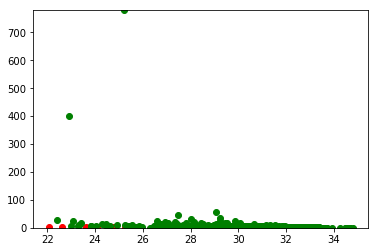

In [6]:
# options for PSF
psf_type ='pixel'
psf_size = 61
psf_size_large = 61
psf_symmetry = 4

# get SExtractor catalog
analysis = Analysis()
cat = system.get_cat(image_name)
#HDUFile, _ = system.get_HDUFile(image_name)
#import astropy.io.fits as pyfits
#HDUFile.writeto('pysex.cat')
#print HDUFile[2].data['X_WORLD']
#pyfits.writeto(filename='HDUFile.fits', data=HDUFile)
#print system.get_header(image_name)

# magnitude-size plot
mag = np.array(cat.data['MAG_BEST'],dtype=float)
mag[mag > 50] = np.mean(mag)
size = np.array(cat.data['FLUX_RADIUS'],dtype=float)

# select stars
kwargs_cuts = analysis.estimate_star_thresholds(cat)
print(kwargs_cuts)
kwargs_cuts['ClassStarMin'] = 0.1
kwargs_cuts['EllipticityThresh'] = 0.8
kwargs_cuts['MagMinThresh'] = 18
kwargs_cuts['MagMaxThresh'] = 26
kwargs_cuts['SizeMinThresh'] = 0.5
kwargs_cuts['SizeMaxThresh'] = 4
mask = analysis.find_objects(cat, kwargs_cuts)
print(np.sum(mask), 'number of stars')
plt.plot(mag[mask > 0], size[mask > 0], 'or')
plt.plot(mag[mask == 0], size[mask == 0], 'og')
plt.ylim([0, np.max(size)])
plt.show()


max iteration reached! stoping
(-14000.797649694014, 'reduced X^2 of best position')
max iteration reached! stoping
(-915.9462905330881, 'reduced X^2 of best position')
max iteration reached! stoping
(-182.42319407211332, 'reduced X^2 of best position')
max iteration reached! stoping
(-203.89365270950086, 'reduced X^2 of best position')
max iteration reached! stoping
(-176.4762929910034, 'reduced X^2 of best position')
max iteration reached! stoping
(-193.5607948873275, 'reduced X^2 of best position')
max iteration reached! stoping
(-212.53978092933812, 'reduced X^2 of best position')
max iteration reached! stoping
(-12458.714019503563, 'reduced X^2 of best position')
max iteration reached! stoping
(-10865.872839285908, 'reduced X^2 of best position')
max iteration reached! stoping
(-113.20344113017815, 'reduced X^2 of best position')
max iteration reached! stoping
(-2061.4288299790746, 'reduced X^2 of best position')
max iteration reached! stoping
(-295.62028837047495, 'reduced X^2 of

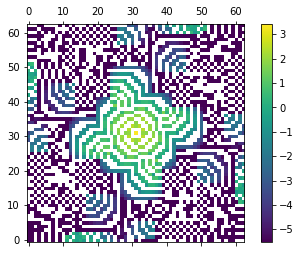

('=== object ===', 1, -0.6886295737431488, -0.7566036186040755)


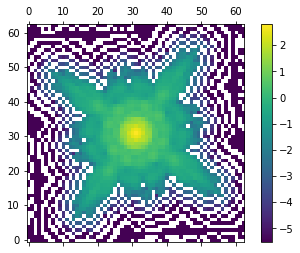

('=== object ===', 2, -0.826517441502851, -0.8017640269463345)


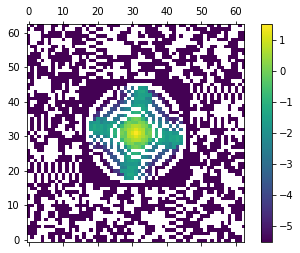

('=== object ===', 3, -1.0780305033929256, -0.3043781368696396)


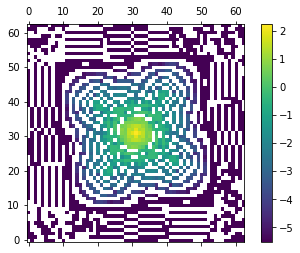

('=== object ===', 4, -1.070958810527044, -0.2813775342538771)


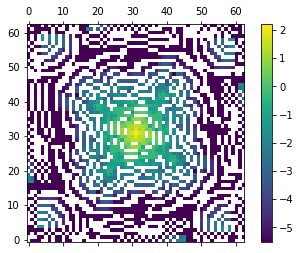

('=== object ===', 5, -0.3005950950357925, -0.6460508960363177)


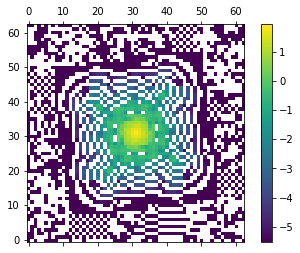

('=== object ===', 6, -0.7381462279466524, -0.11937434042062317)


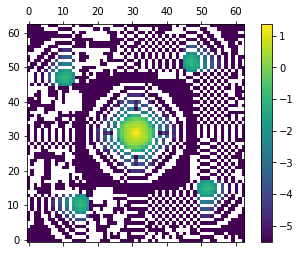

('=== object ===', 7, -8.671336740418782, -0.4786987614789912)


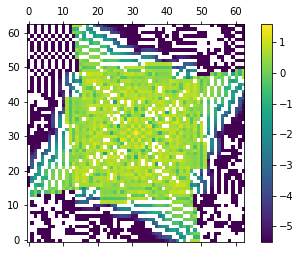

('=== object ===', 8, -25.170133042085002, -16.02802057577339)


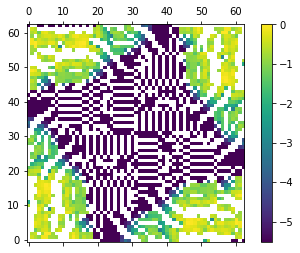

('=== object ===', 9, -0.34857933220466236, -1.2468712280575551)


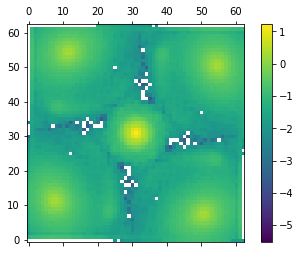

('=== object ===', 10, -0.470706112326401, -0.3190503192848277)


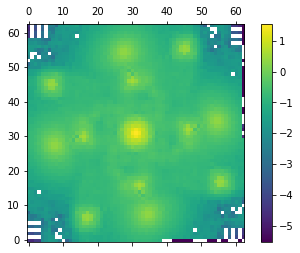

('=== object ===', 11, -0.6968433928332508, -0.4492286379764219)


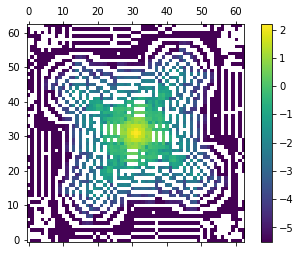

('=== object ===', 12, -0.19500441907507643, -0.11422315257032462)


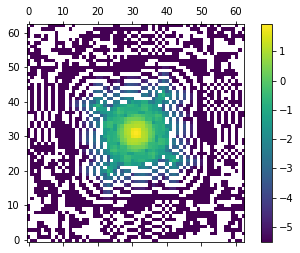

('=== object ===', 13, 0.03031284107624068, -0.8129695390377053)


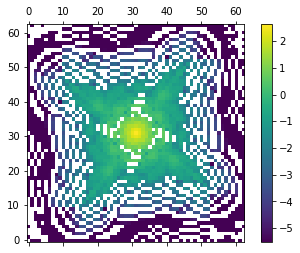

max iteration reached! stoping
(-12663.43820644706, 'reduced X^2 of best position')
max iteration reached! stoping
(-922.4883697949213, 'reduced X^2 of best position')
max iteration reached! stoping
(-182.36056073278107, 'reduced X^2 of best position')
max iteration reached! stoping
(-204.18567429269103, 'reduced X^2 of best position')
max iteration reached! stoping
(-175.8690526165156, 'reduced X^2 of best position')
max iteration reached! stoping
(-242.56925374551548, 'reduced X^2 of best position')
max iteration reached! stoping
(-212.72109647003902, 'reduced X^2 of best position')
max iteration reached! stoping
(-12461.456550125988, 'reduced X^2 of best position')
max iteration reached! stoping
(-10612.964538055949, 'reduced X^2 of best position')
max iteration reached! stoping
(-113.20551671544551, 'reduced X^2 of best position')
max iteration reached! stoping
(-2058.6704962194867, 'reduced X^2 of best position')
max iteration reached! stoping
(-296.2804357223033, 'reduced X^2 of 

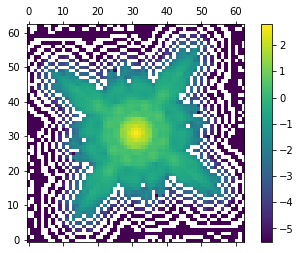

('=== object ===', 3, -1.077865896728329, -0.3171154875962208)


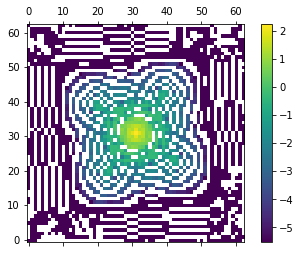

('=== object ===', 5, -0.29216149790370344, -0.6474631409196087)


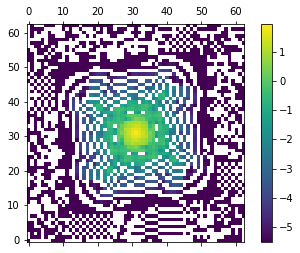

('=== object ===', 12, -0.2064758574912491, -0.09642517651678026)


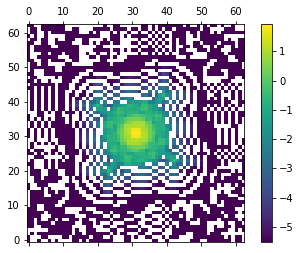

('=== object ===', 13, 0.028876576043904107, -0.8236363123251986)


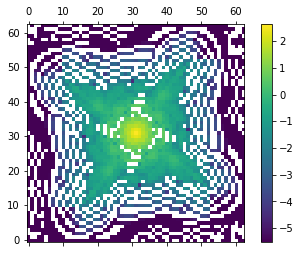

In [8]:
image_full = system.get_full_image(image_name)
image_full -= mean
kernel, mean_list, restrict_psf, star_list = analysis.get_psf(image_full, cat, mean, rms=sigma_b, poisson=exp_time,
                                psf_type='moffat', restrict_psf=None, kwargs_cut=kwargs_cuts, symmetry=psf_symmetry, 
                                                             cutfixed=int(psf_size_large/2)+1,
                                                             #inverse_shift=False
                                                             )

true_list = [1, 3, 5, 12, 13]
for i in range(len(restrict_psf)):
    if i not in true_list:
        restrict_psf[i] = False
kernel, mean_list, restrict_psf, star_list_shifted = analysis.get_psf(image_full, cat, mean, rms=sigma_b,
                                poisson=exp_time, psf_type='moffat', restrict_psf=restrict_psf, kwargs_cut=kwargs_cuts,
                                                                      symmetry=psf_symmetry, 
                                                                      cutfixed=int(psf_size_large/2)+1,
                                                                      #inverse_shift=False
                                                                     )


0.9999999999999998


/Users/ajshajib/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/ajshajib/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10


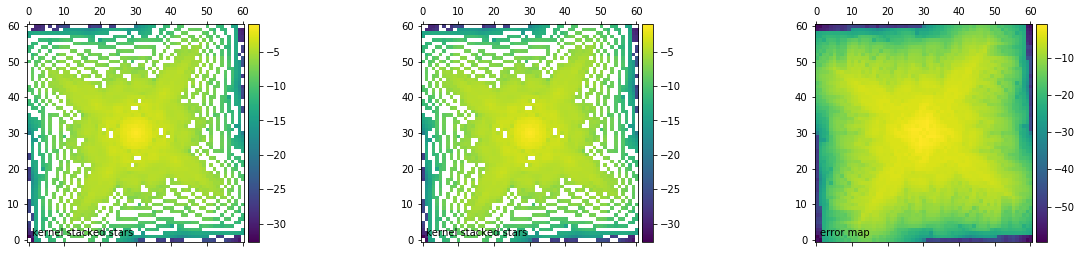

In [9]:
kernel_large_stack = kernel_util.cut_psf(kernel, psf_size=psf_size_large)
kernel_large_pixel = kernel #util.pixel_kernel(kernel)
kernel_pixel = kernel_util.cut_psf(kernel_large_pixel, psf_size=psf_size)
print(np.sum(kernel_large_stack))
from lenstronomy.LightModel.Profiles.shapelets import ShapeletSet
shapelets = ShapeletSet()

kernel_list = shapelets.shapelet_basis_2d(num_order=10, beta=2, numPix=psf_size_large)
kernel_list.append(kernel_large_stack)
error_map = analysis.get_psf_errors(kernel_large_stack, sigma_b, star_list_shifted)


f, axes = plt.subplots(1, 3, figsize=(20, 4), sharex=False, sharey=False)
ax = axes[0]
im = ax.matshow(np.log10(kernel_large_stack), origin='lower')
ax.text(1, 1, 'kernel stacked stars')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax = axes[1]
im = ax.matshow(np.log10(kernel_pixel), origin='lower')
ax.text(1, 1, 'kernel stacked stars')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax = axes[2]
im = ax.matshow(np.log10(error_map), origin='lower')
ax.text(1, 1, 'error map')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()

In [10]:
print(kernel_large_stack.shape)

(61, 61)


(5, (63, 63))


/Users/ajshajib/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


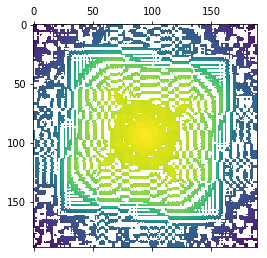

In [11]:
print(len(star_list_shifted), star_list_shifted[0].shape)

plt.matshow(np.log10(kernel_util.subgrid_kernel( star_list_shifted[3], subgrid_res=3)))

In [12]:
psf_filename = 'psf_f160w.hdf5'
local_psf_filename = os.path.join(base_path, 'data', psf_filename)
f = h5py.File(local_psf_filename, "w")
dset = f.create_dataset('kernel_point_source', data=kernel_large_stack)
dset = f.create_dataset('psf_error_map', data=error_map)
f.close()